In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import yaml
import pprint
from databankLibrary import download_link
    
def plotHeadGroup(readme, data, lipid):
    fig= plt.figure(figsize=(10,7))
    for key2,value in data.items():
                            
        #plt.gca().invert_yaxis()
        #plt.ylim([0,1])               
        if lipid == 'POPG' and 'M_G3C6_M' in key2:
            l = None
            plt.plot(0,value[3],"s", color='red', label = l,marker=".", markersize=10)  #color=colors[i],
        if 'M_G3N6' in key2: 
            l = None
            plt.plot(0,value[3],"s",color='red',label = l,marker=".", markersize=10)
        if 'M_G3C5_M' in key2:
            l = None
            plt.plot(1,value[3],"s",color='red',label = l,marker=".", markersize=10)
        if 'M_G3C4_M' in key2:
            l = None
            plt.plot(2,value[3],"s",color='red', label = l,marker=".", markersize=10)
        if 'M_G3_M' in key2:
            l = None
            plt.plot(3,value[3],"s",color='red',label = l,marker=".", markersize=10)
        if 'M_G2_M' in key2:
            l = lipid + " " + readme.get('FF')
            plt.plot(4,value[3],"s",color='red',label = l,marker=".", markersize=10)
        if 'M_G1_M' in key2:
            l = None
            plt.plot(5,value[3],"s",color='red',label = l,marker=".", markersize=10)
        plt.legend( loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
        plt.ylabel('Quality', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
       # plt.ylim(0,-1050)
        plt.title(readme['SYSTEM'] + " DOI: " + doi, fontsize=24)

    return fig



def plotTails(readme,data,name_tail):
    keys_list = list(data.keys())
    tail = []
    if name_tail == 'palmitoyl':
        tail = [x for x in keys_list if 'M_G1C' in x]
    elif name_tail == 'oleoyl':
        tail = [x for x in keys_list if 'M_G2C' in x]
        
    if tail:
        fig1= plt.figure(figsize=(10,7))
        previous_key = ""
        for index, key in enumerate(tail):
            #plt.gca().invert_yaxis()
            #plt.ylim([0,1])
            if key[0:-3] == previous_key[0:-3]:
                plt.plot(index-1,data[key][3],"s",color='red',marker=".", markersize=10)
            else:
                plt.plot(index,data[key][3],"s",color='red',marker=".", markersize=10)
            if key[0:-3] != previous_key[0:-3]:
                previous_key = key
        plt.title(readme['SYSTEM'] + " " + readme['FF'] + " " + name_tail + " DOI: " + doi, fontsize=24)
       # plt.legend(loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
       # plt.ylabel('Quality', fontsize=20)
        return fig1
    else:
        print('No quality data for acyl tails')
        return ""

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

../../Data/QualityEvaluation/0c2/1a9/0c21a9be136ea0eb9df9e5c6cdc19f723a0af245/9ac73b6a98acb54a7a67a5d690794ad7f1e4a1d1/POPC_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/0d5/d1d/0d5d1dcb43e775faf4e53c4f9ff255a67481bd38/9b487701b24d3fad83991e311188b08d3d5ea768/POPG_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/1b2/6e6/1b26e6c750b4f39c37770422cd4d3c40240cf111/995bc873b811ca09c916b47784fa33bb9d793732/POPS_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/25a/ce9/25ace931487aad89f9e755125358282fe99d8ea8/7ce1e2a0f5027d28b81cab28c850ef64d5c9aff5/POPC_OrderParameters.json


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/2b9/b0d/2b9b0d32b79cea2fe66a283bf52e9c1f648393e4/b9251450aa7886b4109908c1ada3d666a77ba77b/POPC_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/2d4/61b/2d461bc9d828af155146162ef42438974e4cbeaf/c8ce4cc36ef6ec7a085cf011176a92d9d746a792/POPE_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/5a4/277/5a427728e5bcc18a6f162a8d325df4a9e4115250/f0fe9b9284aa683f9a419d9173d320cfa31d34cb/POPC_OrderParameters.json


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

../../Data/QualityEvaluation/5e2/0fe/5e20fe22000d94eb54ce0e030c1dd2439796b331/839c970611cedad2e65068b6e412d84c12831ed6/POPC_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/a63/ca7/a63ca7001cbd5cfc328da122668d1aebc00f2c91/220540156a6ac7813942fd01d998a491b6ff9b8b/POPC_OrderParameters.json


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


../../Data/QualityEvaluation/b06/79c/b0679cd5bb4bed509b91a002305d2771ed4ad54e/72ec31258e95aefa0d053131b9e734b4b11eb030/POPC_OrderParameters.json
../../Data/QualityEvaluation/be6/5d5/be65d56aa0b9732c1f75b8e2de40133ac6c5f706/fe08222fa3d4cc603161b05233be0af37dd3cc8b/POPC_OrderParameters.json


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/c74/6ca/c746ca52b71d685e53a802e8046e1253baf6af2b/8850a90345eb033df4ae3228c3b9fa1fbbe40162/POPC_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails
../../Data/QualityEvaluation/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a5a7377c8a46341eba603f320cf7/POPS_OrderParameters.json
No quality data for acyl tails
No quality data for acyl tails


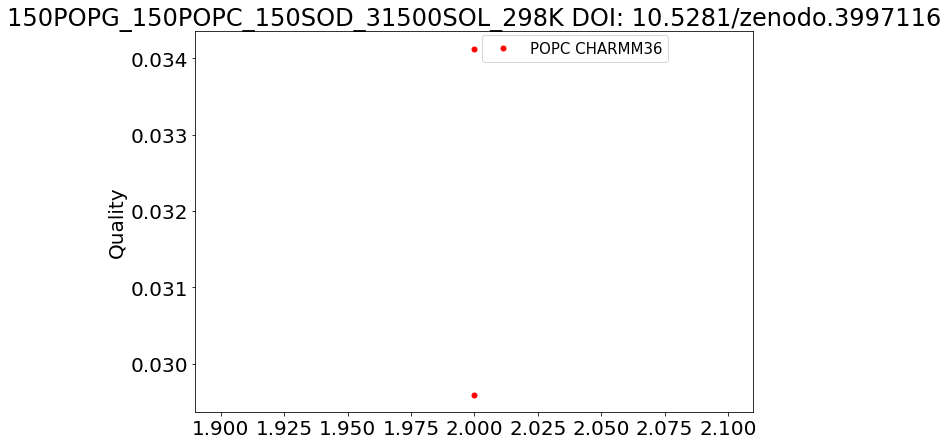

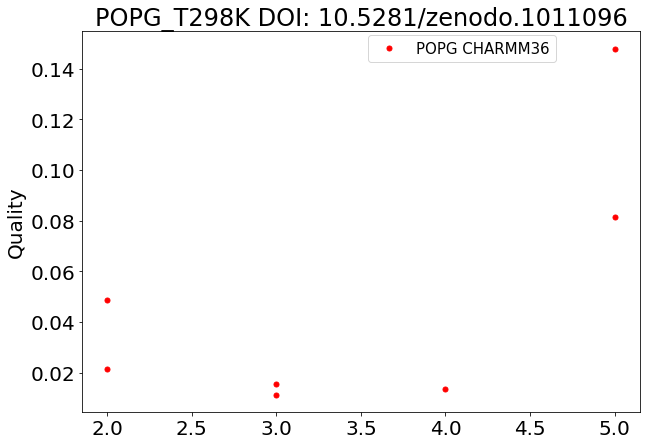

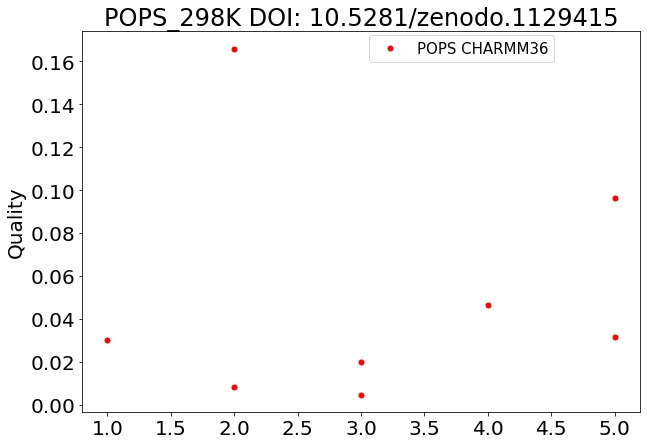

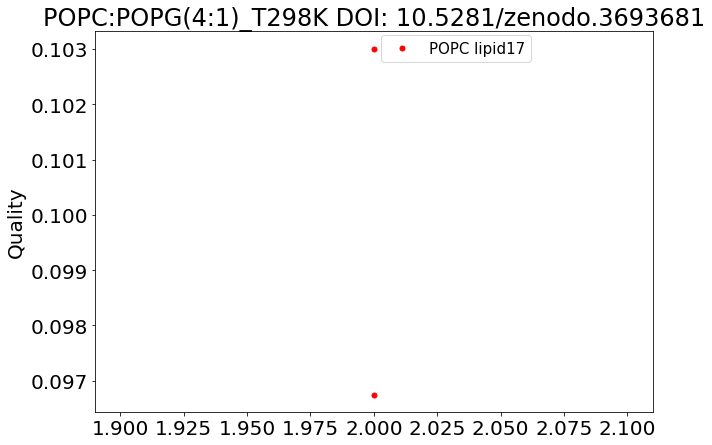

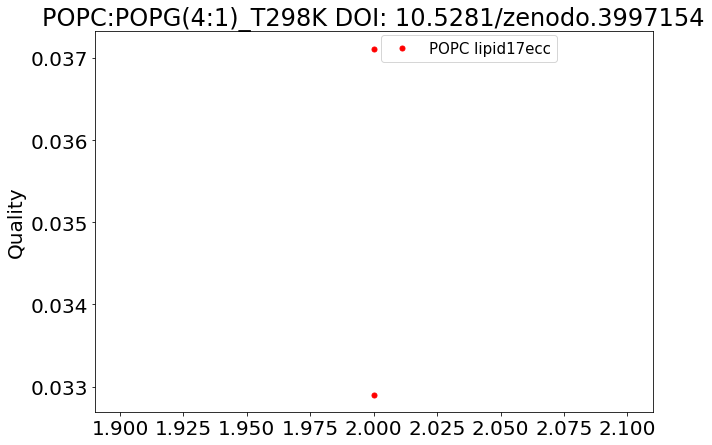

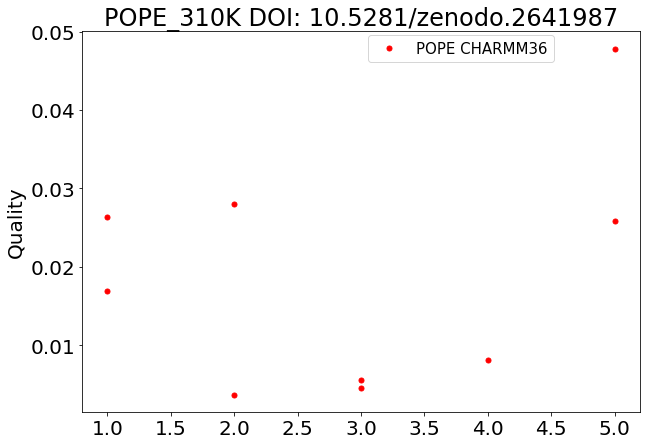

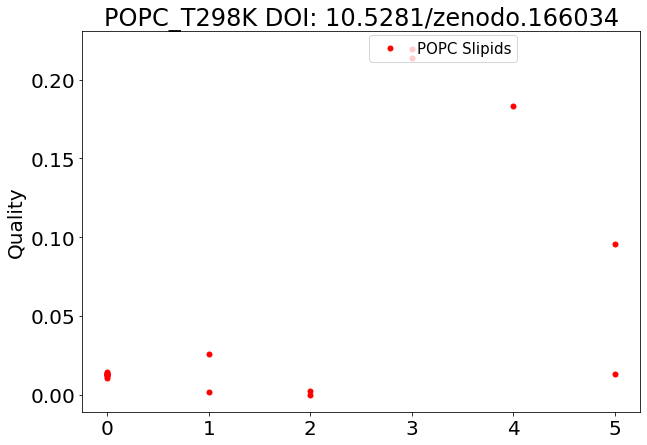

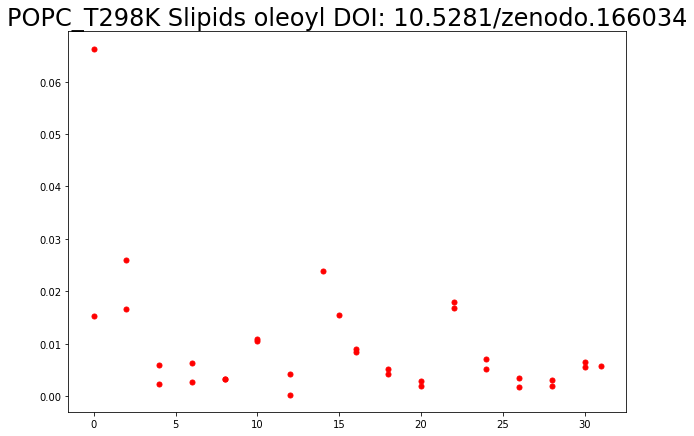

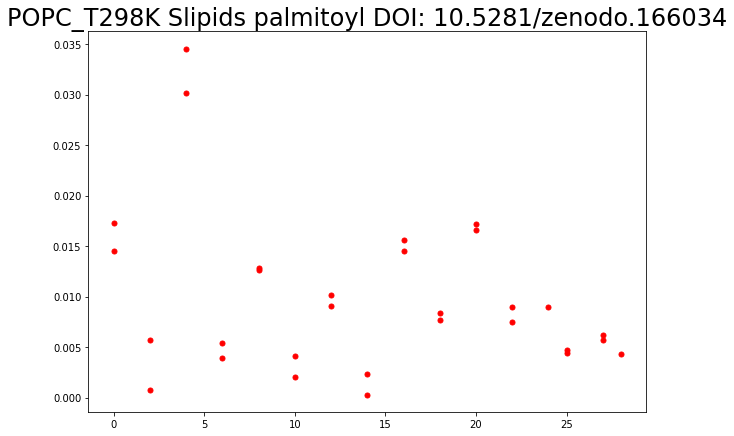

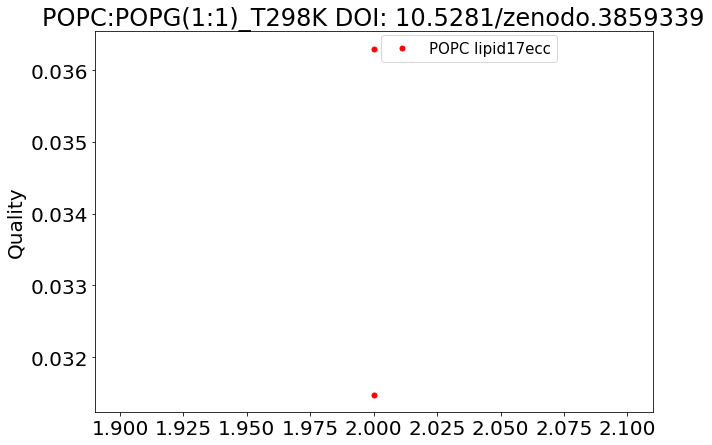

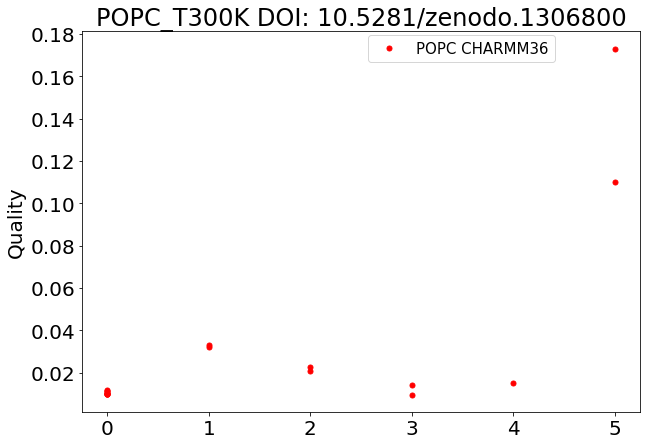

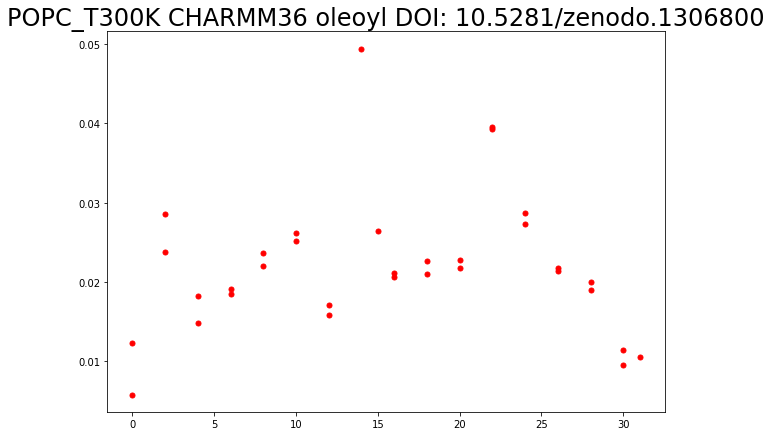

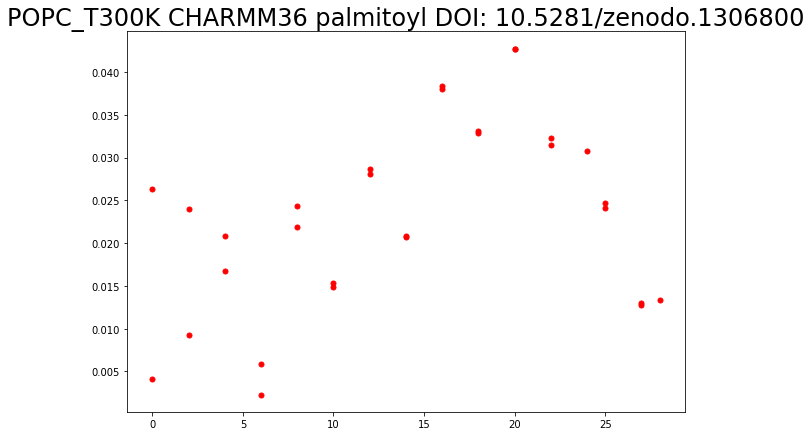

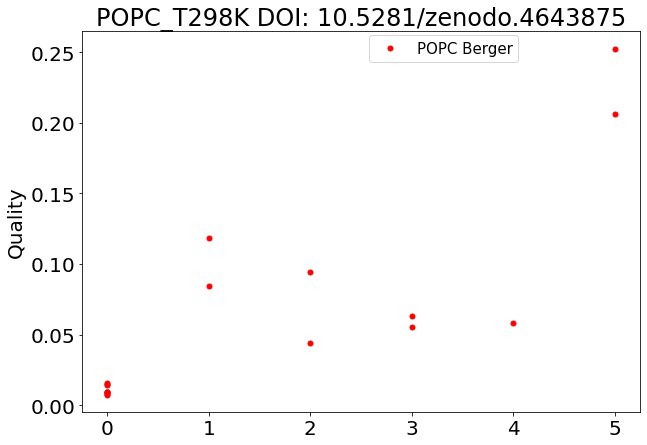

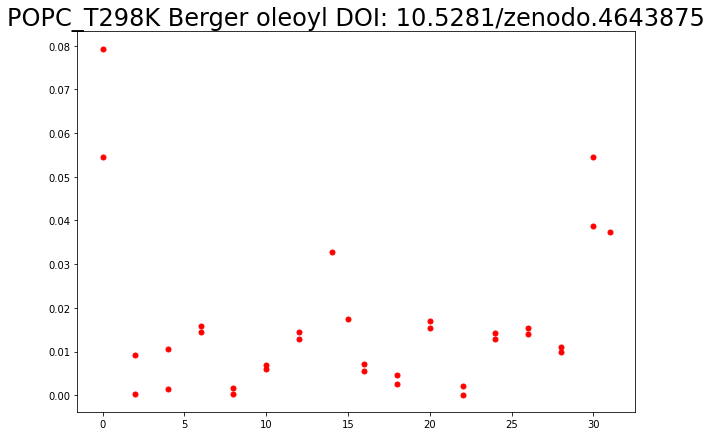

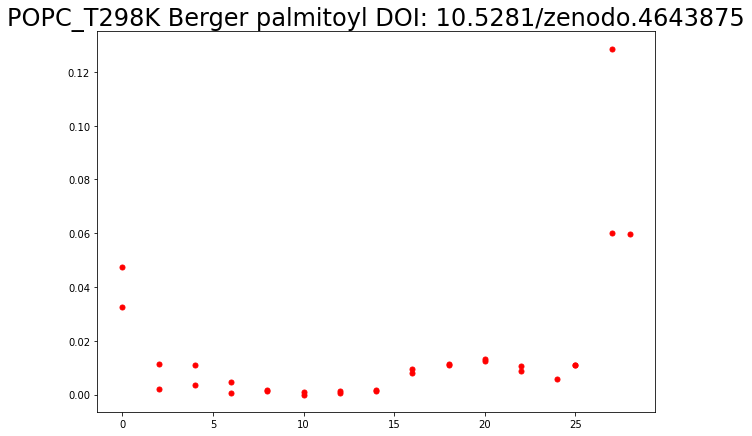

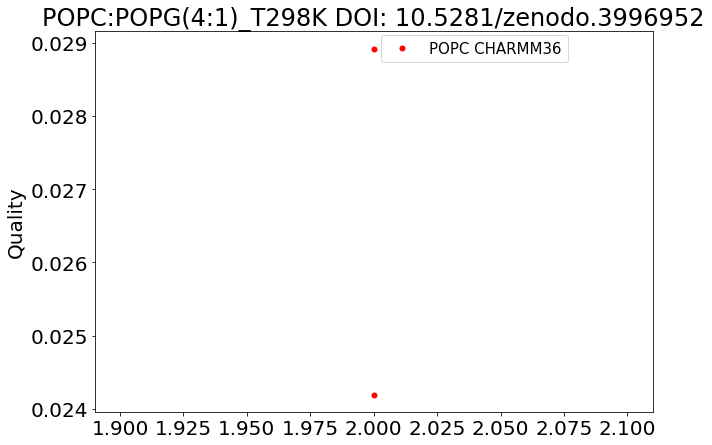

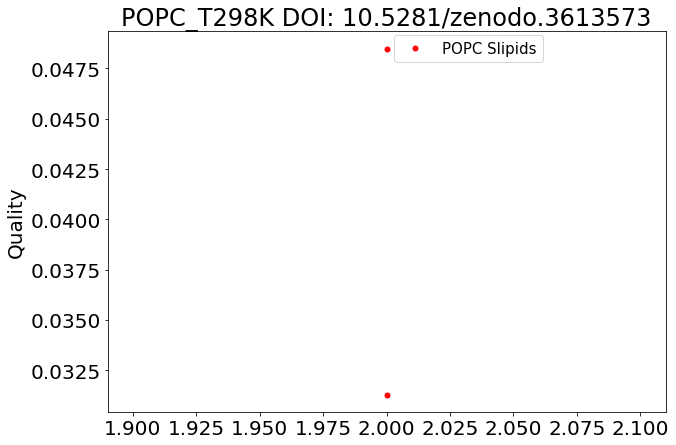

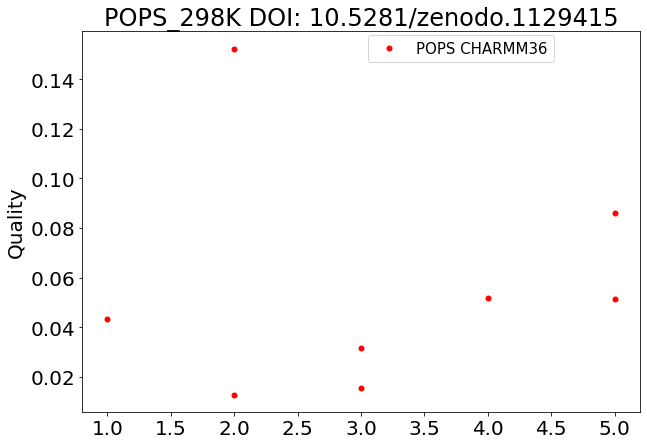

In [5]:
# Demonstration of reading the databank
# Currently lists some information on the simulations in the databank

# This walks through the files in the databank
# Dictionaries saved as README.yaml are read into 'readme' dictionary

for subdir, dirs, files in os.walk(r'../../Data/QualityEvaluation'):
    for filename1 in files:
        filepath1 = subdir + os.sep + filename1
        readme = {}
        if filepath1.endswith("README.yaml"):           
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
            yaml_file.close()
           # print(readme)
            OPdata = {}
            for filename2 in files:
                filepath2 = subdir + os.sep + filename2
                if filepath2.endswith("_OrderParameters.json"):
                    lipid = filename2.replace('_OrderParameters.json', '')
                    print(filepath2)
                    with open(filepath2) as json_file:
                        OPdata[lipid] = json.load(json_file)
                    json_file.close()
                  #  print(OPdata)
            
             #plot head group
                    for key1 in OPdata.keys():
                       # print(readme)
                        data = OPdata[key1]
                        doi = readme['DOI']
                        plotHeadGroup(readme, data, key1) 
                        # plot oleoyl
                        name_tail = ["oleoyl","palmitoyl"]
                        plotTails(readme,data, name_tail[0])
                # plot palmitoyl
                        plotTails(readme,data, name_tail[1])
            
                # plot palmitoyl
                

